## Generate tables and figures for the paper

In [72]:
import os
import pandas as pd
import json


output_dir = "../output"
assert os.path.exists(output_dir)


def read_results(results_path: os.PathLike) -> pd.DataFrame:
    """
    Read the results from the results path.

    Example of results path:
    ```
    output/randomized_greedy/instances_generic/20250722_115309/
    ```
    """
    # list all subdirectories in results_path, which are the instances
    instances = os.listdir(results_path)
    # for every file in an instance, read it and concatenate them
    df = pd.DataFrame()
    for instance in instances:
        configurations = os.listdir(os.path.join(results_path, instance))
        for configuration in configurations:
            file = os.path.join(results_path, instance, configuration)
            # read lines of file, which can be json-decoded, use readlines
            with open(file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    json_line = json.loads(line)
                    # append to dataframe
                    df = pd.concat([df, pd.DataFrame([json_line])])

    # add extra data:
    df["dataset"] = results_path.split("/")[-2]
    df["subdataset"] = df.apply(
        lambda row: row["dataset"] if "release" in row["dataset"] else row["instance_name"].split("_")[0], axis=1
    )
    df["method"] = results_path.split("/")[-3]

    return df


### Part 1: Construction heuristics

Five heuristics were tested:
- Randomized Construction
- MIP bias-randomized construction
- MIP construction - alpha
- MIP construction - beta
- Simple construction


In [73]:

# define map of results directories timestamp per method and instance_set
results_map = {
    "randomized_greedy": {
        "instances_generic": "20250722_115309",
        "instances_release_1": "20250722_113250",
        "instances_release_2": "20250722_120238"
    },
    "mip_randomized_construction_bias": {
        "instances_generic": "20250722_175122",
        "instances_release_1": "20250722_215350",
        "instances_release_2": "20250722_234800"
    },
    "mip_randomized_construction_random_alpha": {
        "instances_generic": "20250722_152024",
        "instances_release_1": "20250722_163300",
        "instances_release_2": "20250722_170730"
    },
    "mip_randomized_construction_random_beta": {
        "instances_generic": "20250722_153855",
        "instances_release_1": "20250722_164312",
        "instances_release_2": "20250722_171920"
    },
    "simple_randomized": {
        "instances_generic": "20250722_125153",
        "instances_release_1": "20250722_124750",
        "instances_release_2": "20250722_124529"
    }
}

from tqdm import tqdm


dataset_name = "construction_heuristics.csv"

def get_results(rebuild=False):
    if rebuild or not os.path.exists(dataset_name):
        print(f"Building dataset {dataset_name}")
        # build a big dataset with all the results
        results = pd.DataFrame()
        for method in tqdm(results_map.keys(), desc="Methods"):
            for instance_set in tqdm(results_map[method].keys(), desc="Instance Sets", leave=False):
                results_path = f"{output_dir}/{method}/{instance_set}/{results_map[method][instance_set]}"
                df = read_results(results_path)
                results = pd.concat([results, df])
        results.to_csv(dataset_name, index=False)
        print(f"Dataset {dataset_name} built")
    else:
        print(f"Dataset {dataset_name} already exists")
        results = pd.read_csv(dataset_name)

    return results

results = get_results()

display(results.head())
print(f"Number of rows: {len(results)}")
print(f"Number of columns: {len(results.columns)}")
print(f"Methods: {results['method'].unique()}")

Dataset construction_heuristics.csv already exists


,parameters_hash,instance_name,instance_file,method,alpha,tour,cost,wall_time,timestamp,dataset,subdataset,time_limit,construction_type,beta
0,1.182789e+19,decrease_n_15_r_225_0.txt,instances/instances_generic/decrease_n_15_r_22...,randomized_greedy,0.0,"0,11,1,4,14,7,3,2,6,5,13,12,8,10,9",17689.359375,0.000054,20250722_115434,instances_generic,decrease,NaN,NaN,NaN
1,1.182789e+19,decrease_n_15_r_225_0.txt,instances/instances_generic/decrease_n_15_r_22...,randomized_greedy,0.0,"0,11,1,4,14,7,3,2,6,5,13,12,8,10,9",17689.359375,0.000051,20250722_115434,instances_generic,decrease,NaN,NaN,NaN
2,1.182789e+19,decrease_n_15_r_225_0.txt,instances/instances_generic/decrease_n_15_r_22...,randomized_greedy,0.0,"0,11,1,4,14,7,3,2,6,5,13,12,8,10,9",17689.359375,0.000053,20250722_115434,instances_generic,decrease,NaN,NaN,NaN
3,1.182789e+19,decrease_n_15_r_225_0.txt,instances/instances_generic/decrease_n_15_r_22...,randomized_greedy,0.0,"0,11,1,4,14,7,3,2,6,5,13,12,8,10,9",17689.359375,0.000052,20250722_115434,instances_generic,decrease,NaN,NaN,NaN
4,1.182789e+19,decrease_n_15_r_225_0.txt,instances/instances_generic/decrease_n_15_r_22...,randomized_greedy,0.0,"0,11,1,4,14,7,3,2,6,5,13,12,8,10,9",17689.359375,0.000052,20250722_115434,instances_generic,decrease,NaN,NaN,NaN


Number of rows: 42297
Number of columns: 14
Methods: ['randomized_greedy' 'mip_randomized_construction_bias'
 'mip_randomized_construction_random_alpha'
 'mip_randomized_construction_random_beta' 'simple_randomized']


### Alpha plot for randomized_greedy

Dataset construction_heuristics.csv already exists


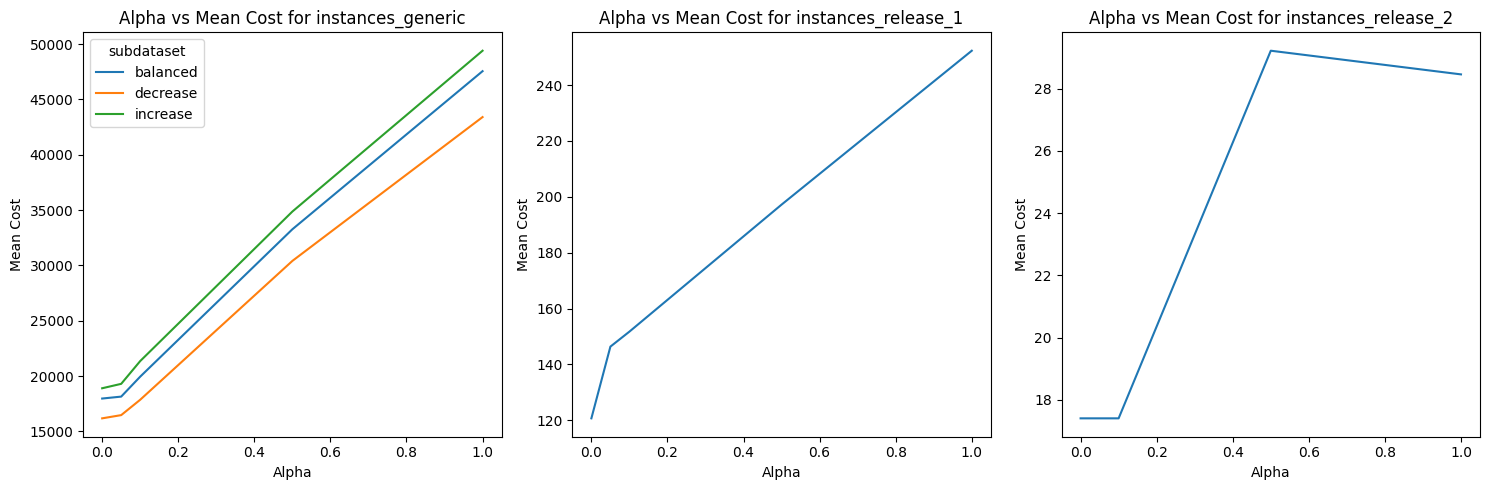

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

results = get_results()


results["success"] = results["cost"] != float('inf')
import numpy as np
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Alpha plot for randomized_greedy
rg = results[results["method"] == "randomized_greedy"]
# compute avg cost and std per dataset and alpha value
rg_avg_cost = rg.groupby(['dataset', 'subdataset', 'alpha'])['cost'].agg(['mean', 'std']).reset_index()

# Plot these values, separate dataset per plot, and arrange plots from left to right
unique_datasets = rg_avg_cost['dataset'].unique()
num_datasets = len(unique_datasets)
fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=False)

for ax, dataset in zip(axes, unique_datasets):
    dataset_data = rg_avg_cost[rg_avg_cost['dataset'] == dataset]
    # if more than one subdataset, plot each subdataset in a different color
    if len(dataset_data['subdataset'].unique()) > 1:
        sns.lineplot(x="alpha", y="mean", data=dataset_data, hue="subdataset", ax=ax)
    else:
        sns.lineplot(x="alpha", y="mean", data=dataset_data, ax=ax)
    ax.set_title(f"Alpha vs Mean Cost for {dataset}")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Mean Cost")

plt.tight_layout()
plt.show()



### Alpha plot for mip construction alpha and beta plot for mip construction beta


Dataset construction_heuristics.csv already exists


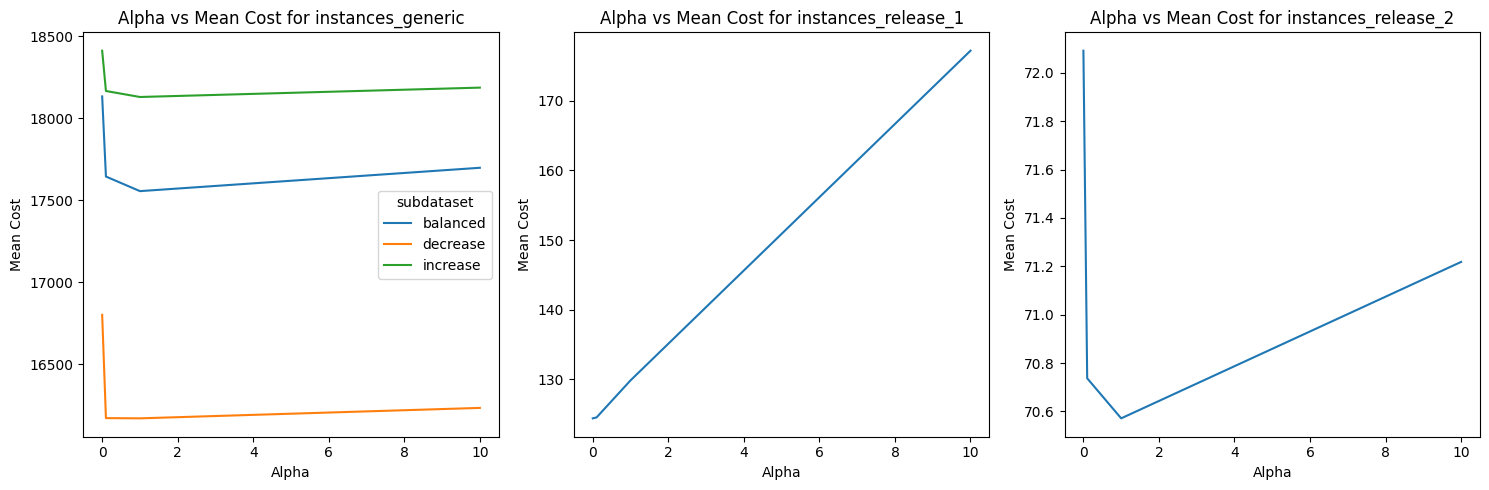

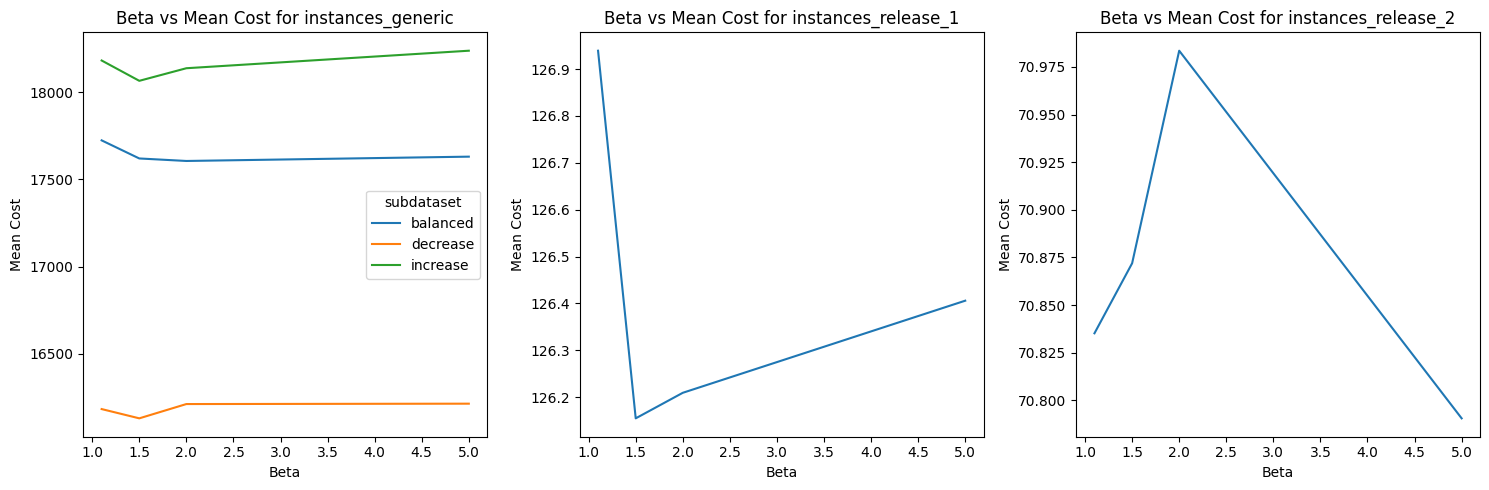

In [75]:
# mip construction alpha and beta plot for mip construction beta

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = get_results()


results["success"] = results["cost"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

def plot_alpha_beta(mip_avg_cost: np.ndarray, param: str, title: str) -> None:
    """
    Plots the mean cost against the given parameter (alpha or beta) for each dataset.

    :param mip_avg_cost: The aggregated cost data.
    :param param: The parameter to plot against ('alpha' or 'beta').
    :param title: The title for the plot.
    """
    unique_datasets = mip_avg_cost['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print(f"No datasets available for {title}.")
        return
    
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=False)
    
    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = mip_avg_cost[mip_avg_cost['dataset'] == dataset]
        if len(dataset_data['subdataset'].unique()) > 1:
            sns.lineplot(x=param, y="mean", data=dataset_data, hue="subdataset", ax=ax)
        else:
            sns.lineplot(x=param, y="mean", data=dataset_data, ax=ax)
        ax.set_title(f"{param.capitalize()} vs Mean Cost for {dataset}")
        ax.set_xlabel(param.capitalize())
        ax.set_ylabel("Mean Cost")
    
    plt.tight_layout()
    plt.show()

# Alpha plot for mip construction alpha
mip_alpha = results[results["method"] == "mip_randomized_construction_random_alpha"]
mip_alpha_avg_cost = mip_alpha.groupby(['dataset', 'subdataset', 'alpha'])['cost'].agg(['mean', 'std']).reset_index()
plot_alpha_beta(mip_alpha_avg_cost, 'alpha', 'Alpha Plot for MIP Construction Alpha')

# Beta plot for mip construction beta
mip_beta = results[results["method"] == "mip_randomized_construction_random_beta"]
mip_beta_avg_cost = mip_beta.groupby(['dataset', 'subdataset', 'beta'])['cost'].agg(['mean', 'std']).reset_index()
plot_alpha_beta(mip_beta_avg_cost, 'beta', 'Beta Plot for MIP Construction Beta')

### Alpha-beta plot for mip construction bias

Dataset construction_heuristics.csv already exists


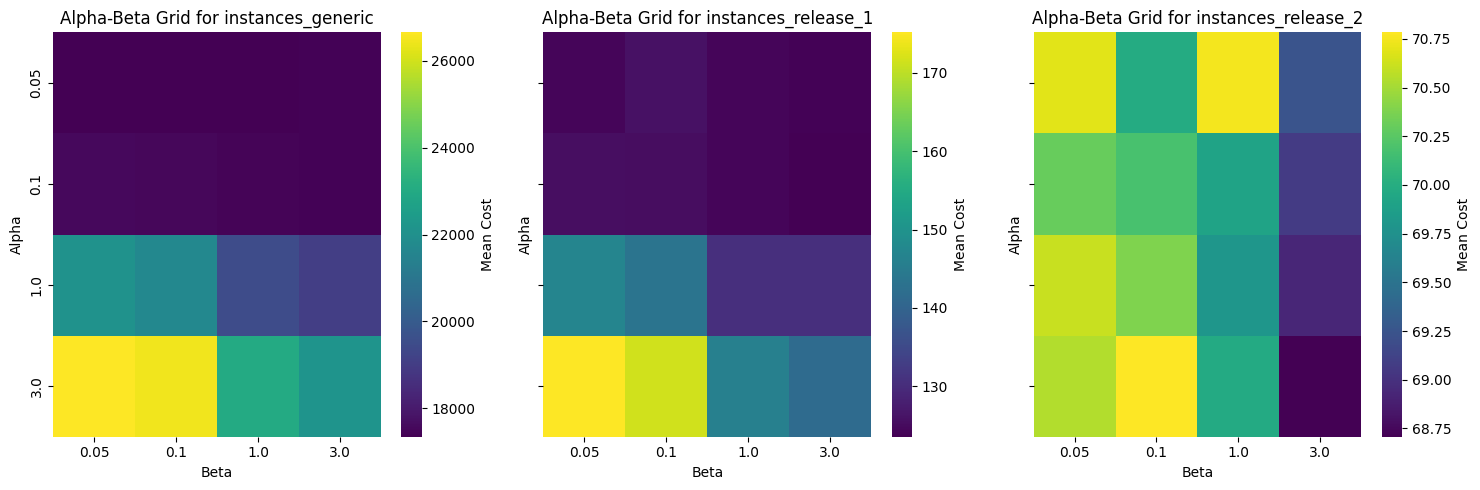

In [76]:
# mip construction alpha and beta plot for mip construction bias

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = get_results()


# Ensure success column is correctly set
results["success"] = results["cost"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter results for the specific method
filtered_results = results[results["method"] == "mip_randomized_construction_bias"]

# Group by dataset, subdataset, alpha, and beta to calculate mean cost
bias_avg_cost = filtered_results.groupby(['dataset', 'subdataset', 'alpha', 'beta'])['cost'].mean().reset_index()

def plot_alpha_beta_grid(bias_avg_cost: pd.DataFrame) -> None:
    """
    Plots a 2D grid of alpha vs beta with mean cost as the color intensity for each dataset.

    :param bias_avg_cost: The aggregated cost data with alpha and beta.
    """
    unique_datasets = bias_avg_cost['dataset'].unique()
    num_datasets = len(unique_datasets)
    
    if num_datasets == 0:
        print("No datasets available for plotting.")
        return
    
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5), sharey=True)
    
    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for ax, dataset in zip(axes, unique_datasets):
        dataset_data = bias_avg_cost[bias_avg_cost['dataset'] == dataset]
        # Use pivot_table with aggregation to handle duplicates
        pivot_table = dataset_data.pivot_table(index="alpha", columns="beta", values="cost", aggfunc='mean')
        sns.heatmap(pivot_table, ax=ax, cmap="viridis", cbar_kws={'label': 'Mean Cost'})
        ax.set_title(f"Alpha-Beta Grid for {dataset}")
        ax.set_xlabel("Beta")
        ax.set_ylabel("Alpha")
    
    plt.tight_layout()
    plt.show()

# Plot the alpha-beta grid
plot_alpha_beta_grid(bias_avg_cost)


### Now we want to choose the best setting for each method, one choice per dataset

In [90]:
alpha_randomized_greedy = 0.05
alpha_mip_randomized_construction_bias = 0.05
beta_mip_randomized_construction_bias = 3

alpha_mip_randomized_construction_random_alpha = 0.1
beta_mip_randomized_construction_random_beta = 1.5

def filter_results_by_method(results: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the results DataFrame based on specific method criteria.

    :param results: The DataFrame containing the results to filter.
    :return: A filtered DataFrame.
    """
    def apply_filter(row: pd.Series) -> bool:
        if row["method"] == "randomized_greedy":
            return row["alpha"] == alpha_randomized_greedy
        if row["method"] == "mip_randomized_construction_bias":
            return (row["alpha"] == alpha_mip_randomized_construction_bias) and (row["beta"] == beta_mip_randomized_construction_bias)
        elif row["method"] == "mip_randomized_construction_random_alpha":
            return row["alpha"] == alpha_mip_randomized_construction_random_alpha
        elif row["method"] == "mip_randomized_construction_random_beta":
            return row["beta"] == beta_mip_randomized_construction_random_beta
        return True

    return results[results.apply(apply_filter, axis=1)]

results = get_results()

before = len(results)
results = filter_results_by_method(results)
after = len(results)
print(f"Filtered {before - after} rows")

# Ensure success column is correctly set
results["success"] = results["cost"] != float('inf')
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# Correct the groupby to use a list for multiple columns
aggregated_results = results.groupby(['dataset', 'method']).agg(
    mean_cost=('cost', 'mean'),
    std_cost=('cost', 'std'),
    success_rate=('success', 'mean')
).reset_index()

rename_dataset = {
    "instances_generic": "RG",
    "instances_release_1": "C1",
    "instances_release_2": "C2"
}

aggregated_results["dataset"] = aggregated_results["dataset"].map(rename_dataset)

# Pivot the DataFrame to have 'method' as rows, 'dataset' as columns, and 'mean_cost', 'std_cost' as subcolumns
aggregated_results = aggregated_results.pivot_table(
    index='method',
    columns='dataset',
    values=['mean_cost', 'std_cost', 'success_rate']
)

# display the table
display(aggregated_results)


Dataset construction_heuristics.csv already exists
Filtered 34075 rows


mean_cost                           \
dataset                                           C1         C2            RG   
method                                                                          
mip_randomized_construction_bias          123.952762  69.243254  17400.327735   
mip_randomized_construction_random_alpha  124.536572  70.736941  17327.160809   
mip_randomized_construction_random_beta   126.154952  70.871941  17271.670279   
randomized_greedy                         146.390611  17.410000  17975.378084   
simple_randomized                         242.093957        NaN  46757.199864   

                                            std_cost                           \
dataset                                           C1         C2            RG   
method                                                                          
mip_randomized_construction_bias           93.057061  34.291054   3598.843219   
mip_randomized_construction_random_alpha   93.243262  35.833626   3487.152743   
mip_randomized_construction_random_beta    93.782945  35.894407   3489.957135   
randomized_greedy                          88.629568   0.000000   5206.532491   
simple_randomized                         106.988324        NaN  16632.199436   

                                         success_rate                 
dataset                                            C1        C2   RG  
method                                                                
mip_randomized_construction_bias             1.000000  0.994118  1.0  
mip_randomized_construction_random_alpha     1.000000  1.000000  1.0  
mip_randomized_construction_random_beta      1.000000  1.000000  1.0  
randomized_greedy                            0.857143  0.029412  1.0  
simple_randomized                            0.457143  0.000000  1.0